Epoch [1/5], Loss: 121.6719
Epoch [2/5], Loss: 82.4995
Epoch [3/5], Loss: 77.1247
Epoch [4/5], Loss: 74.5553
Epoch [5/5], Loss: 72.8221


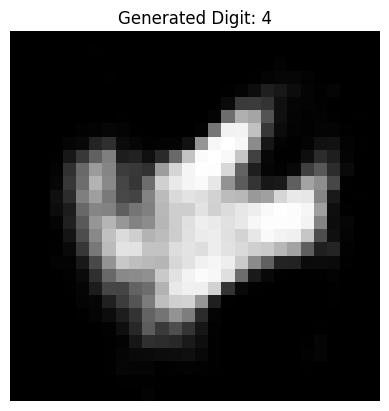

✅ Generated Single Number: 4


In [ ]:
# ------------------- Step 1: Import Libraries -------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

# ------------------- Step 2: Parameters & Load Dataset -------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 28
batch_size = 128
latent_dim = 20
num_epochs = 5
learning_rate = 1e-3

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------- Step 3: Encoder -------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

# ------------------- Step 4: Decoder -------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28*28)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.tanh(self.fc2(h))  # outputs in [-1,1]
        return x_recon.view(-1, 1, 28, 28)

# ------------------- Step 5: VAE -------------------
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# ------------------- Step 6: Loss Function -------------------
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# ------------------- Step 7: Train VAE -------------------
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        recon, mu, logvar = model(images)
        loss = vae_loss(recon, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader.dataset):.4f}")

# ------------------- Step 8: Load Pretrained MNIST Classifier -------------------
# We'll use a simple classifier trained on MNIST
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

classifier = Classifier().to(device)

# Train classifier quickly for demonstration
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion_cls = nn.CrossEntropyLoss()

for epoch in range(3):  # few epochs for demo
    classifier.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        loss = criterion_cls(outputs, labels)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

# ------------------- Step 9: Generate a Single Number -------------------
model.eval()
classifier.eval()
with torch.no_grad():
    z = torch.randn(1, latent_dim).to(device)  # single latent sample
    generated_image = model.decoder(z)
    output = classifier(generated_image)
    predicted_digit = torch.argmax(output, dim=1).item()

    # Show image
    plt.imshow(generated_image.cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Digit: {predicted_digit}")
    plt.show()

print(f"✅ Generated Single Number: {predicted_digit}")
